In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Data Discovery - Use SQL to explore what's inside the data source
### this section is not part of the main project which uses mainly SQLAlchemy, Pandas DataFrame, and Matplotlib to generate results. I am using this section to check what's inside the tables of the data source

In [10]:
# show data in Measurement table
engine.execute('select * from measurement limit 20').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0)]

In [11]:
# show Measurement table column names (keys)
engine.execute('select * from measurement limit 20').keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
# show Station table
engine.execute('select * from station limit 20').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# show Station table column names (keys)
engine.execute('select * from station limit 20').keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# find the last day's date in data set
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
first_date = session.query(Measurement.date).order_by(Measurement.date).first()

# as SQLAlchemy results are tuples, to extract date to string, just extract the first element
end_date = end_date[0]
first_date = first_date[0]
# Calculate the date 1 year ago from the last data point in the database, use 366 days to include 2016-08-23
start_date = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_weather_data = pd.DataFrame(query_result, columns=['date', 'precipitation'])


# Sort the dataframe by date
df_weather_data.set_index('date', inplace=True)
df_weather_data.sort_values(by='date', ascending=True)
df_weather_data = df_weather_data[pd.notnull(df_weather_data['precipitation'])]
df_weather_data.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [15]:
# Create user input for start_date and end_date for vacation trip
start_date_input = input(f"Let us pick a start date for the trip in YYYY-MM-DD format (range between {first_date} and {end_date:}): ")
year, month, day = map(int, start_date_input.split('-'))
trip_start_date = dt.date(year, month, day)

end_date_input = input(f"Let us pick an end date for the trip in YYYY-MM-DD format (range between {trip_start_date}) and {end_date}): ")
year, month, day = map(int, end_date_input.split('-'))
trip_end_date = dt.date(year, month, day)

print(f"Your trip start date is: {trip_start_date}")
print(f"Your trip end date is: {trip_end_date}")

Let us pick a start date for the trip in YYYY-MM-DD format (range between 2010-01-01 and 2017-08-23): 2016-01-08
Let us pick an end date for the trip in YYYY-MM-DD format (range between 2016-01-08) and 2017-08-23): 2016-01-21
Your trip start date is: 2016-01-08
Your trip end date is: 2016-01-21


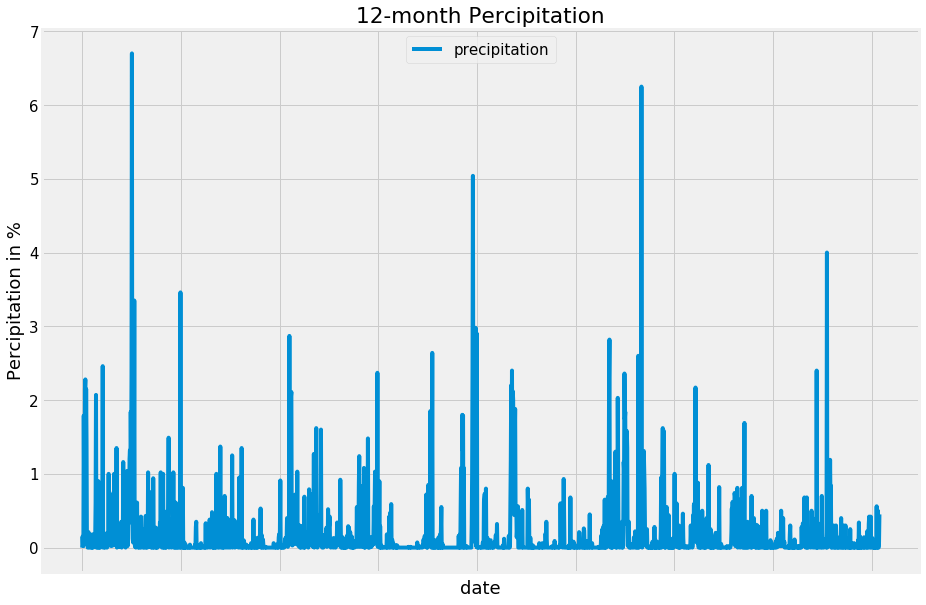

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
df_weather_data.plot(title='12-month Percipitation', figsize=(14,10))
plt.legend(loc='upper center')
plt.ylabel('Percipitation in %')
plt.rcParams.update({'font.size': 15})
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_weather_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Measurement.station).distinct().count()
print(f"Numbers of Stations: {count_stations}")

Numbers of Stations: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

print(f"The most active station is: {active_stations[0][0]}\n")
print(f"List of Station Activities from Most Active to Least Active: ")
df_active_stations = pd.DataFrame(active_stations, columns=['Station ID', 'Activity Count'])
df_active_stations

The most active station is: USC00519281

List of Station Activities from Most Active to Least Active: 


,Station ID,Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_stations[0][0]

most_active_station_temps = session.query(
        Measurement.station.label('Station ID'),
        func.min(Measurement.tobs).label('Max Temp'), 
        func.max(Measurement.tobs).label('Min Temp'), 
        func.avg(Measurement.tobs).label('Avg Temp')).\
        filter(Measurement.station == most_active_station).all()

print(f"Most Active Station Tempreture Stats:")
df_temp_stat = pd.DataFrame(most_active_station_temps).set_index('Station ID').transpose()
df_temp_stat

Most Active Station Tempreture Stats:


Station ID,USC00519281
Max Temp,54.000000
Min Temp,85.000000
Avg Temp,71.663781


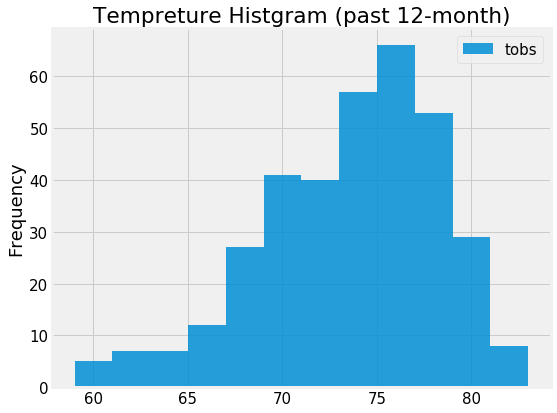

In [24]:
# Choose the station with the highest number of temperature observations.
most_temp_observed_station = session.query(
        Measurement.station,
        func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
        first()

most_temp_observed_station

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observed_temp_data = session.query(Measurement.tobs).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.station == most_temp_observed_station[0]).all()

df_observed_temp_data = pd.DataFrame(observed_temp_data, columns=['tobs'])

months = 12

df_observed_temp_data.plot.hist(bins=months, title='Tempreture Histgram (past 12-month)', figsize=(8, 6), alpha=0.85)
plt.tight_layout()
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps(trip_start_date, trip_end_date)

df_my_trip = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])
df_my_trip

,tmin,tavg,tmax
0,61.0,69.134146,78.0


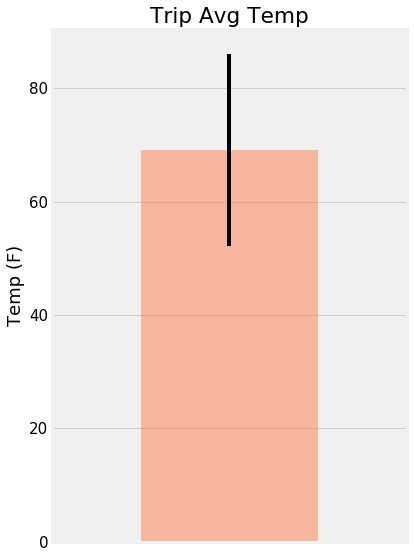

In [31]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

diff = df_my_trip['tmax'] - df_my_trip['tmin']

ax = df_my_trip.plot.bar(title='Trip Avg Temp', y='tavg', yerr=diff, color='coral', alpha=0.5, figsize = (6, 8))
plt.ylabel('Temp (F)')
plt.xticks([]) # disable xticks
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def percipitation(start_date, end_date):
    
    sel = [
        Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        Measurement.prcp
    ]
    
    return session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= trip_start_date).\
        filter(Measurement.date <= trip_end_date).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

df_my_trip_prcp = pd.DataFrame(percipitation('2016-01-01', '2016-01-15'))

df_my_trip_prcp.head()


,station,name,latitude,longitude,elevation,prcp
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.02
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.01
2,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.01
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.00


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# build a list of dates in the range of start to end
# need to figure out how to d othis in a list comprehension style
date_range = []
x = trip_start_date
delta = dt.timedelta(days=1)
while x <= trip_end_date:
    date_range.append(x)
    x += delta
    
# date_range

In [35]:
# build a new trip daily normal function
def trip_daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == func.strftime("%m-%d", date)).all()

trip_daily_normal_result = []
for y in date_range:
    trip_daily_normal_result.append(trip_daily_normals(y))

trip_daily_normal_result

# insert dates back into the list

[[(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)],
 [(57.0, 67.25454545454545, 77.0)],
 [(58.0, 69.52631578947368, 77.0)],
 [(56.0, 69.31372549019608, 78.0)],
 [(54.0, 68.62962962962963, 80.0)],
 [(61.0, 69.07407407407408, 76.0)],
 [(57.0, 68.63157894736842, 77.0)],
 [(60.0, 68.26315789473684, 78.0)],
 [(61.0, 68.86666666666666, 78.0)],
 [(61.0, 70.14545454545454, 76.0)]]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(trip_daily_normal_result, columns=['data'])

# using a cool values.tolist() function to split list inside list into columns
df = pd.DataFrame(df.data.values.tolist(), columns=['Min Temp','Avg Temp','Max Temp'])

# now add those dates back into the dataframe
df['Date'] = date_range

df = df.set_index('Date')

print(f"\nBelow are the dataframe generated from trip made between {trip_start_date} and {trip_end_date}.")
df.head()


Below are the dataframe generated from trip made between 2016-01-08 and 2016-01-21.


,Min Temp,Avg Temp,Max Temp
Date,,,
2016-01-08,57.0,67.160714,75.0
2016-01-09,58.0,67.929825,78.0
2016-01-10,62.0,69.741379,77.0
2016-01-11,57.0,67.310345,78.0
2016-01-12,57.0,67.407407,81.0


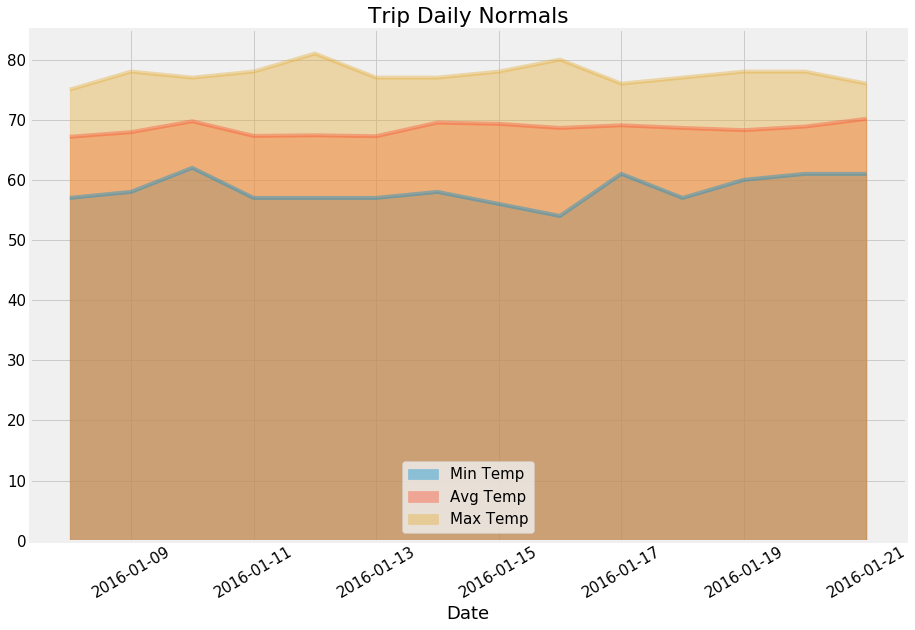

In [43]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked = False, alpha=0.4, title="Trip Daily Normals", figsize=(13,9))
plt.legend(loc = "lower center")
plt.xticks(rotation=30)
plt.tight_layout()
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()